# CASO DE ESTUDIO 2 - MODELO DE REDES CONVOLUCIONALES


## 1. Business Case Discovery

### 1.1 Contexto del negocio y antecedentes (resumido)
El reconocimiento automatico de los digitos en el proceso de clasificacion de correspondencia puede agilizar y reducir costos operativos

### 1.2 Objetivo del proyecto
Desarrollar un sistema de reconocimiento de digitos que identifique digitos y permita automatizar el ruteo y clasificacion en funcion del codigo postal

### 1.3 Metricas de exito
- **Precision(Accuracy)**: Porcentaje de digitos reconocidos correctamente
- **Tiempo de inferencia**: Tiempo requerido para procesar las imagenes
- **Numero de parametros**: Comparacion de la eficiencia del modelo, evaluando complejidad y generalizacion

### 1.4 Desafios y consideraciones
- **Calidad y variabilidad de las imagenes**
- **Overfitting y Underfitting**

--- 

## 2. Data processing
Se usara el dataset de MNIST.

70.000 imagenes en escala de grises con tamaño de imagen 28x28 y de digitos manuscritos del 0 a 9

#### Importacion de librerias

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
import io
import base64
import os


#### Carga de datos

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Visualizacion de los datos

#### Algunos ejemplos de imagenes

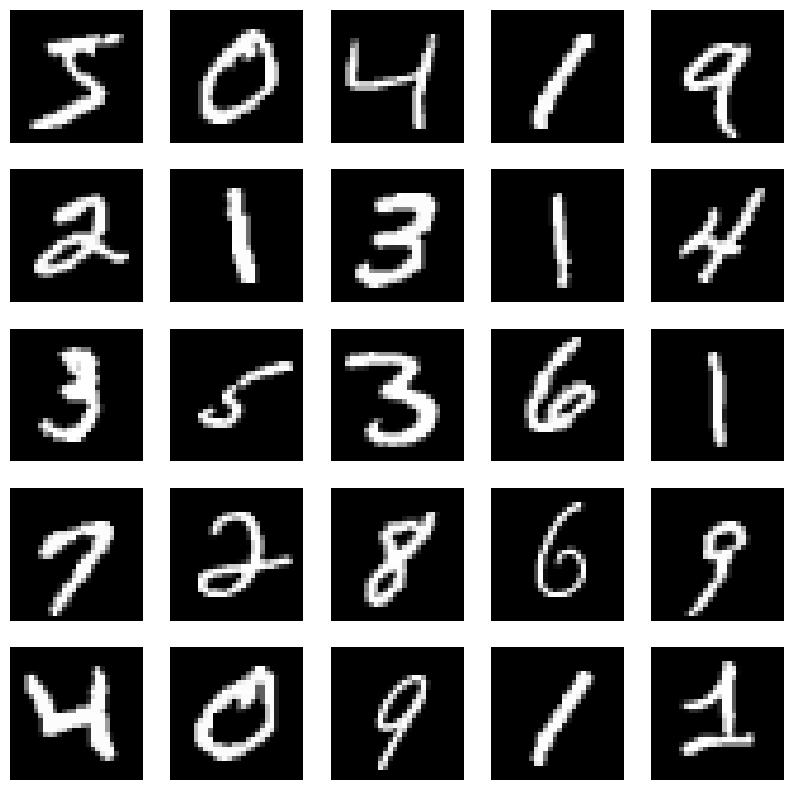

In [20]:
# Visualizar algunas imágenes del dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
plt.show()

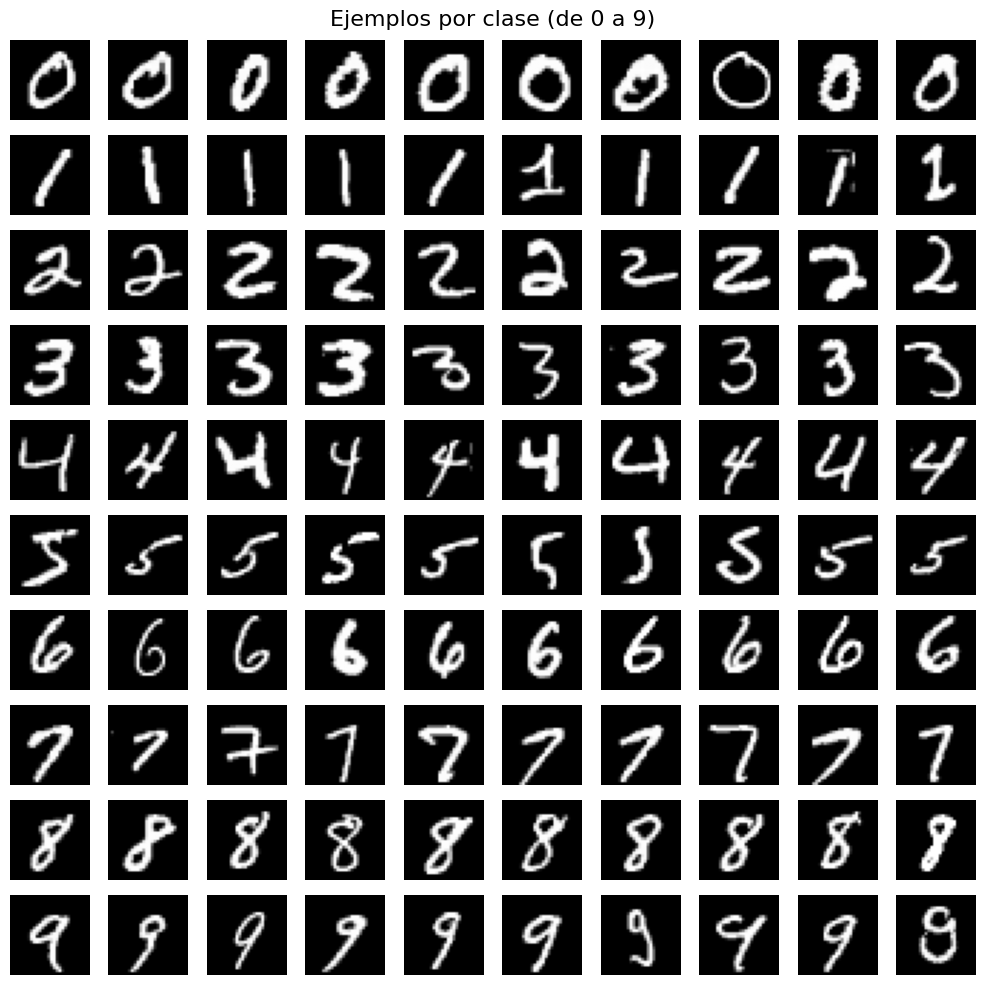

In [21]:
import matplotlib.pyplot as plt

def show_examples_by_class(x_data, y_data, samples_per_class=10):
    plt.figure(figsize=(samples_per_class, 10))
    for digit in range(10):
        idxs = np.where(y_data == digit)[0][:samples_per_class]
        for i, idx in enumerate(idxs):
            plt_idx = digit * samples_per_class + i + 1
            plt.subplot(10, samples_per_class, plt_idx)
            plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.ylabel(str(digit), fontsize=14)
    plt.suptitle("Ejemplos por clase (de 0 a 9)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Llama a la función con tus datos
show_examples_by_class(x_train, y_train)


#### Representacion de los datos

In [22]:

def representar_dataset(y_train=y_train):
    # Contar cuántos hay de cada dígito
    unique, counts = np.unique(y_train, return_counts=True)
    percentages = counts / counts.sum() * 100  # Convertimos a porcentaje

    # Crear DataFrame con los valores de clase y sus frecuencias
    df_freq = pd.DataFrame({'Dígito': unique, 'Cantidad': counts})
    df_freq = df_freq.set_index('Dígito')

    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    # Histograma de las etiquetas (dígitos)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.countplot(x=y_train, ax=ax1)
    ax1.set_title("Distribución de clases en dataset MNIST")
    ax1.set_xlabel("Dígitos")
    ax1.set_ylabel("Cantidad de imágenes")
    ax1.grid(True, axis='y', linestyle='-')

    # Histograma de porcentajes
    ax2 = fig.add_subplot(gs[0, 1])
    sns.barplot(x=unique, y=percentages, ax=ax2)
    ax2.set_title("Distribución porcentual de las clases en MNIST")
    ax2.set_xlabel("Dígitos")
    ax2.set_ylabel("Porcentaje (%)")
    ax2.set_ylim(0, max(percentages) + 2)
    for i, v in enumerate(percentages):
        ax2.text(i, v + 0.5, f"{v:.2f}%", ha='center', rotation=90, size=12)

    # Mapa de calor
    ax3 = fig.add_subplot(gs[1, :])
    sns.heatmap(df_freq.T, annot=True, fmt='d', cmap="YlGnBu", cbar=True, ax=ax3)
    ax3.set_title("Distribución de dígitos (heatmap)")
    ax3.set_xlabel("Dígito")
    ax3.set_ylabel("")
    for text in ax3.texts:
        text.set_rotation(45)
        text.set_size(16)

    plt.tight_layout(pad=3.0)
    plt.show()



In [23]:
def show_images(title, indices, x_train=x_train, y_train=y_train):
    plt.figure(figsize=(15, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, 10, i+1)
        plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
        plt.title(f"{y_train[idx]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


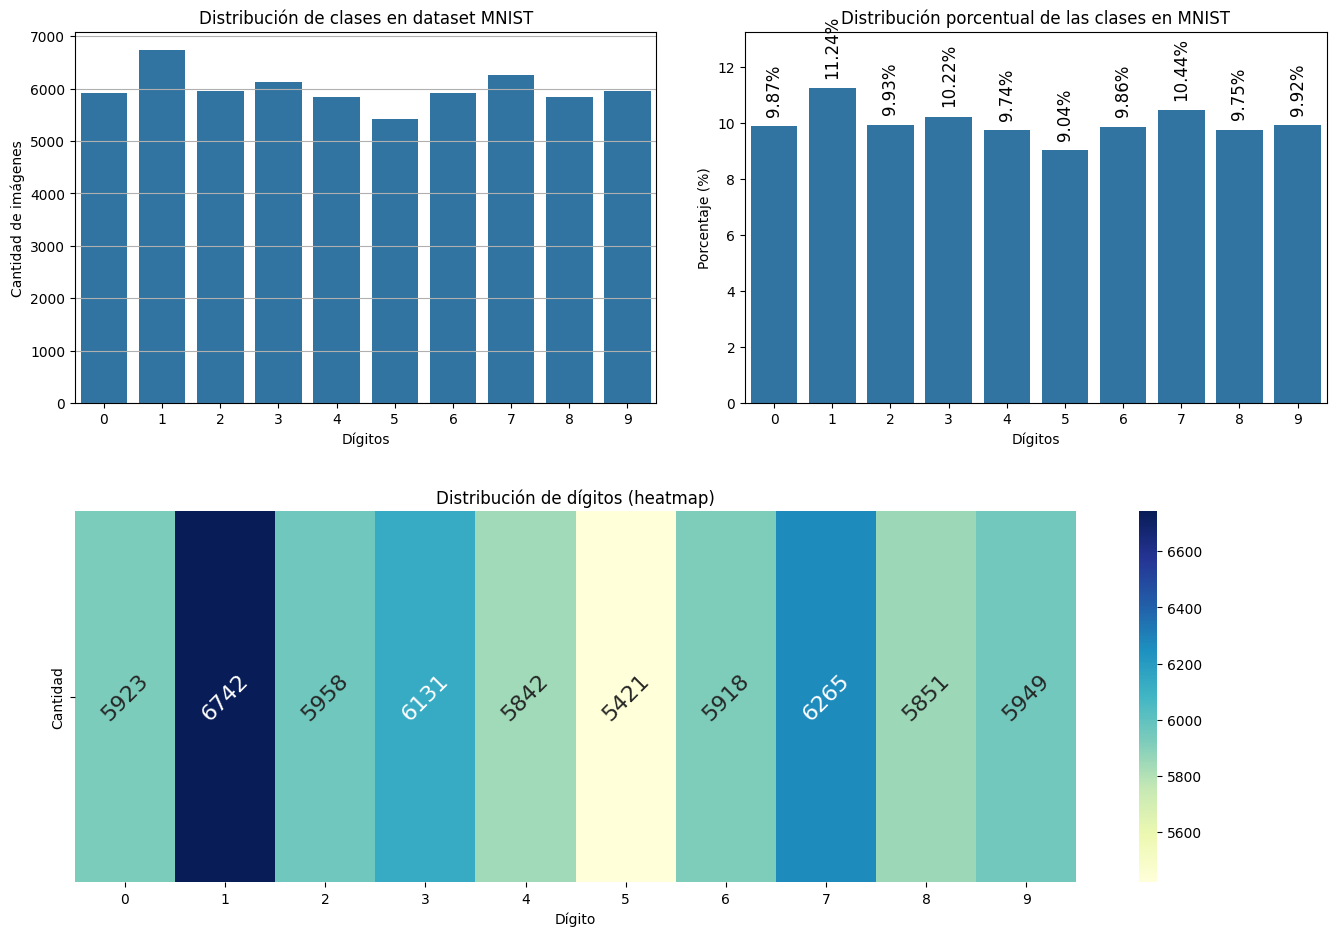

In [24]:
representar_dataset(y_train=y_train)

#### Detección de posibles anomalías

##### Definicion de threshold

In [25]:
pixel_sums = x_train.reshape(x_train.shape[0], -1).sum(axis=1)

print("Mínima suma de píxeles:", pixel_sums.min())
print("Máxima suma de píxeles:", pixel_sums.max())

threshold_low = np.percentile(pixel_sums, 0.1)   # Umbral bajo (0.1%)
threshold_high = np.percentile(pixel_sums, 98) # Umbral alto (98%)

low_pixel_idxs = np.where(pixel_sums <= threshold_low)[0]
high_pixel_idxs = np.where(pixel_sums >= threshold_high)[0]


Mínima suma de píxeles: 5086
Máxima suma de píxeles: 79483


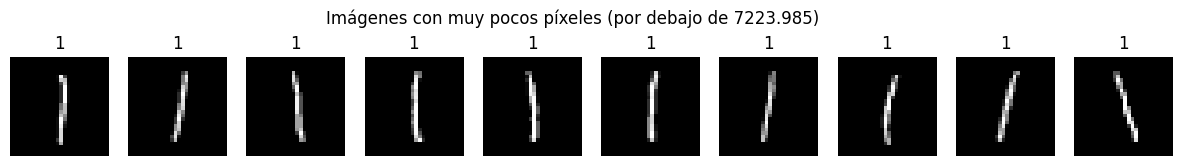

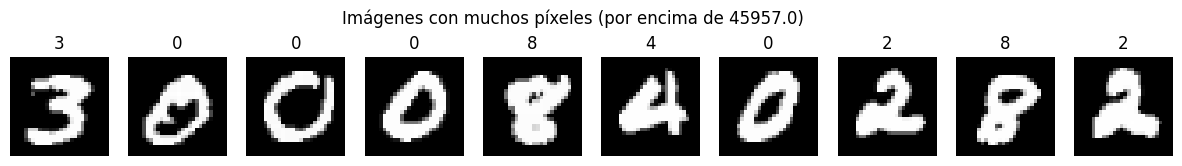

In [26]:

show_images(f"Imágenes con muy pocos píxeles (por debajo de {threshold_low})", low_pixel_idxs[:10])
show_images(f"Imágenes con muchos píxeles (por encima de {threshold_high})", high_pixel_idxs[:10])


Número de imágenes con píxeles altos: 1201


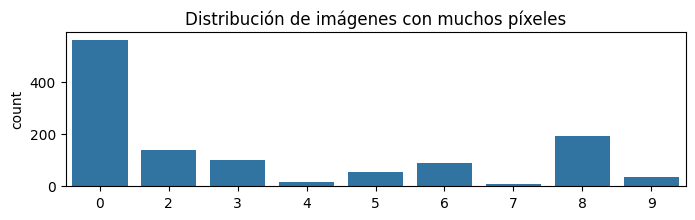

In [27]:
high_pixel_labels = y_train[high_pixel_idxs]

# Contar cuántas imágenes tienen píxeles altos
print(f"Número de imágenes con píxeles altos: {len(high_pixel_idxs)}")

plt.figure(figsize=(8,2))
sns.countplot(x=high_pixel_labels)
plt.title("Distribución de imágenes con muchos píxeles")
plt.show()

##### Limpieza quitando los que pasan de umbral

In [28]:
print(f"Tamaño original de x_train: {x_train.shape}")
print(f"Tamaño original de y_train: {y_train.shape}")

# Eliminar las imágenes con píxeles altos
x_train_cleaned = np.delete(x_train, high_pixel_idxs, axis=0)
y_train_cleaned = np.delete(y_train, high_pixel_idxs, axis=0)

print(f"Nuevo tamaño de x_train: {x_train_cleaned.shape}")
print(f"Nuevo tamaño de y_train: {y_train_cleaned.shape}")

Tamaño original de x_train: (60000, 28, 28)
Tamaño original de y_train: (60000,)
Nuevo tamaño de x_train: (58799, 28, 28)
Nuevo tamaño de y_train: (58799,)


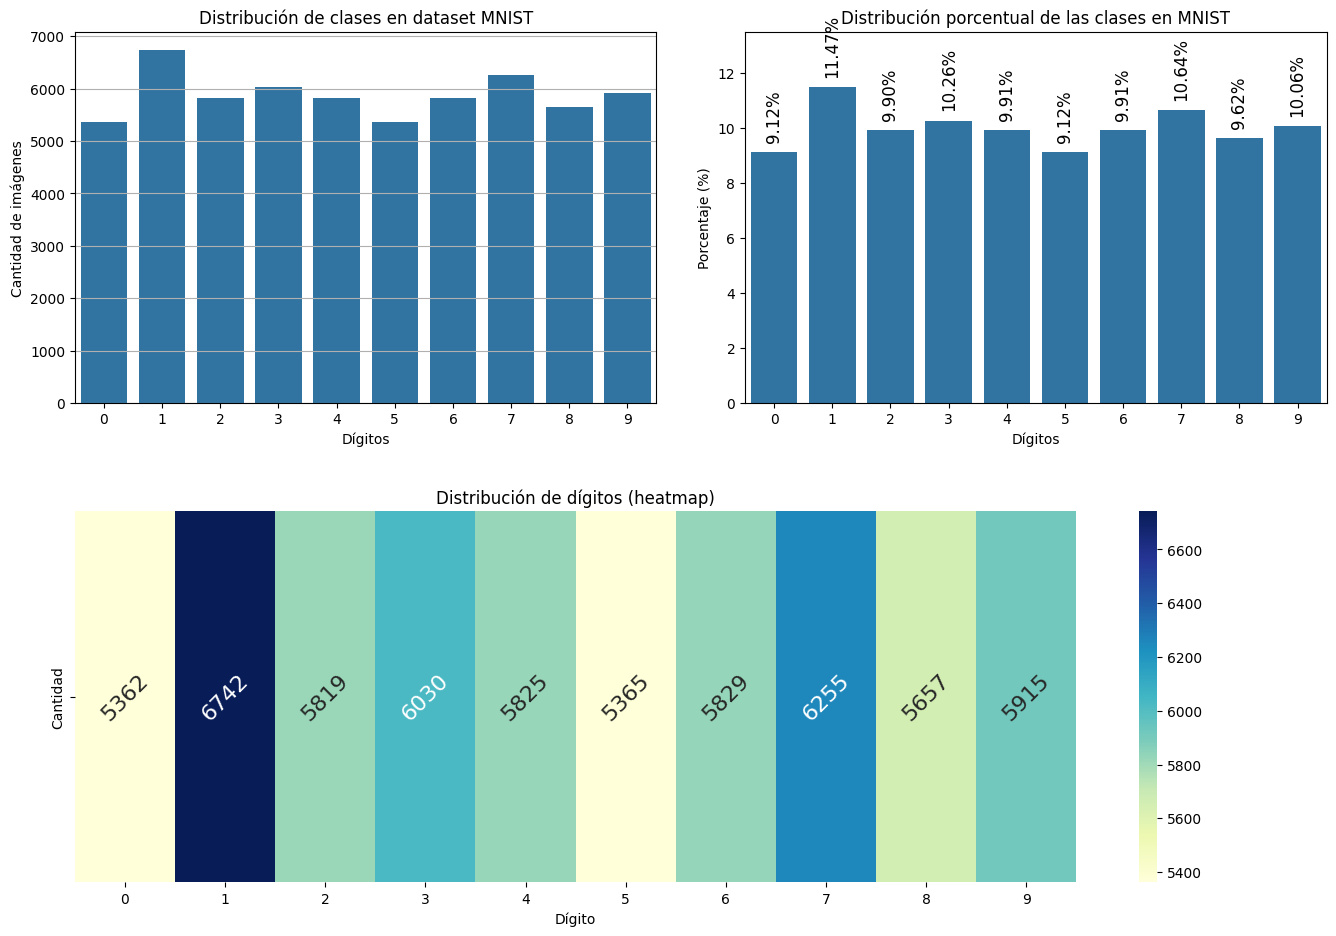

In [29]:
representar_dataset(y_train=y_train_cleaned)

##### Definicion de nuevo threshold

In [30]:
pixel_sums_cleaned = x_train_cleaned.reshape(x_train_cleaned.shape[0], -1).sum(axis=1)

print("Cleaned - Mínima suma de píxeles:", pixel_sums_cleaned.min())
print("Cleaned - Máxima suma de píxeles:", pixel_sums_cleaned.max())

threshold_low_cleaned = np.percentile(pixel_sums_cleaned, 0.1)   # Umbral bajo (0.1%)
threshold_high_cleaned = np.percentile(pixel_sums_cleaned, 98) # Umbral alto (98%)

low_pixel_idxs_cleaned = np.where(pixel_sums_cleaned <= threshold_low_cleaned)[0]
high_pixel_idxs_cleaned = np.where(pixel_sums_cleaned >= threshold_high_cleaned)[0]


Cleaned - Mínima suma de píxeles: 5086
Cleaned - Máxima suma de píxeles: 45949


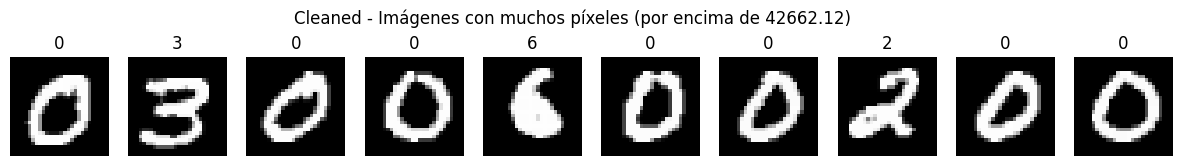

In [31]:
show_images(f"Cleaned - Imágenes con muchos píxeles (por encima de {threshold_high_cleaned})",
            high_pixel_idxs_cleaned[:10],
            x_train=x_train_cleaned, 
            y_train=y_train_cleaned)


Cleaned - Número de imágenes con píxeles altos: 1176


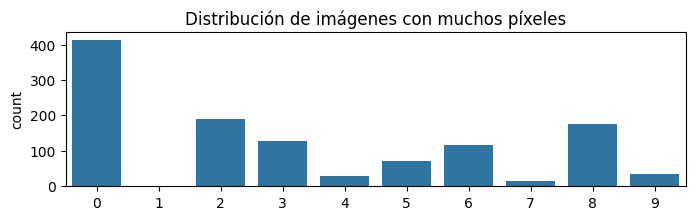

In [32]:
high_pixel_labels_cleaned = y_train_cleaned[high_pixel_idxs_cleaned]

# Contar cuántas imágenes tienen píxeles altos
print(f"Cleaned - Número de imágenes con píxeles altos: {len(high_pixel_idxs_cleaned)}")

plt.figure(figsize=(8,2))
sns.countplot(x=high_pixel_labels_cleaned)
plt.title("Distribución de imágenes con muchos píxeles")
plt.show()

##### Limpieza quitando los que pasan del nuevo umbral 

In [33]:
print(f"Tamaño original de x_train_cleaned: {x_train_cleaned.shape}")
print(f"Tamaño original de y_train_cleaned: {y_train_cleaned.shape}")

high_pixel_non_zero_idxs = high_pixel_idxs_cleaned[y_train_cleaned[high_pixel_idxs_cleaned] != 0]

# Eliminar las imágenes con píxeles altos
x_train_final = np.delete(x_train_cleaned, high_pixel_non_zero_idxs, axis=0)
y_train_final = np.delete(y_train_cleaned, high_pixel_non_zero_idxs, axis=0)

print(f"Nuevo tamaño de x_train_final: {x_train_final.shape}")
print(f"Nuevo tamaño de y_train_final: {y_train_final.shape}")

Tamaño original de x_train_cleaned: (58799, 28, 28)
Tamaño original de y_train_cleaned: (58799,)
Nuevo tamaño de x_train_final: (58037, 28, 28)
Nuevo tamaño de y_train_final: (58037,)


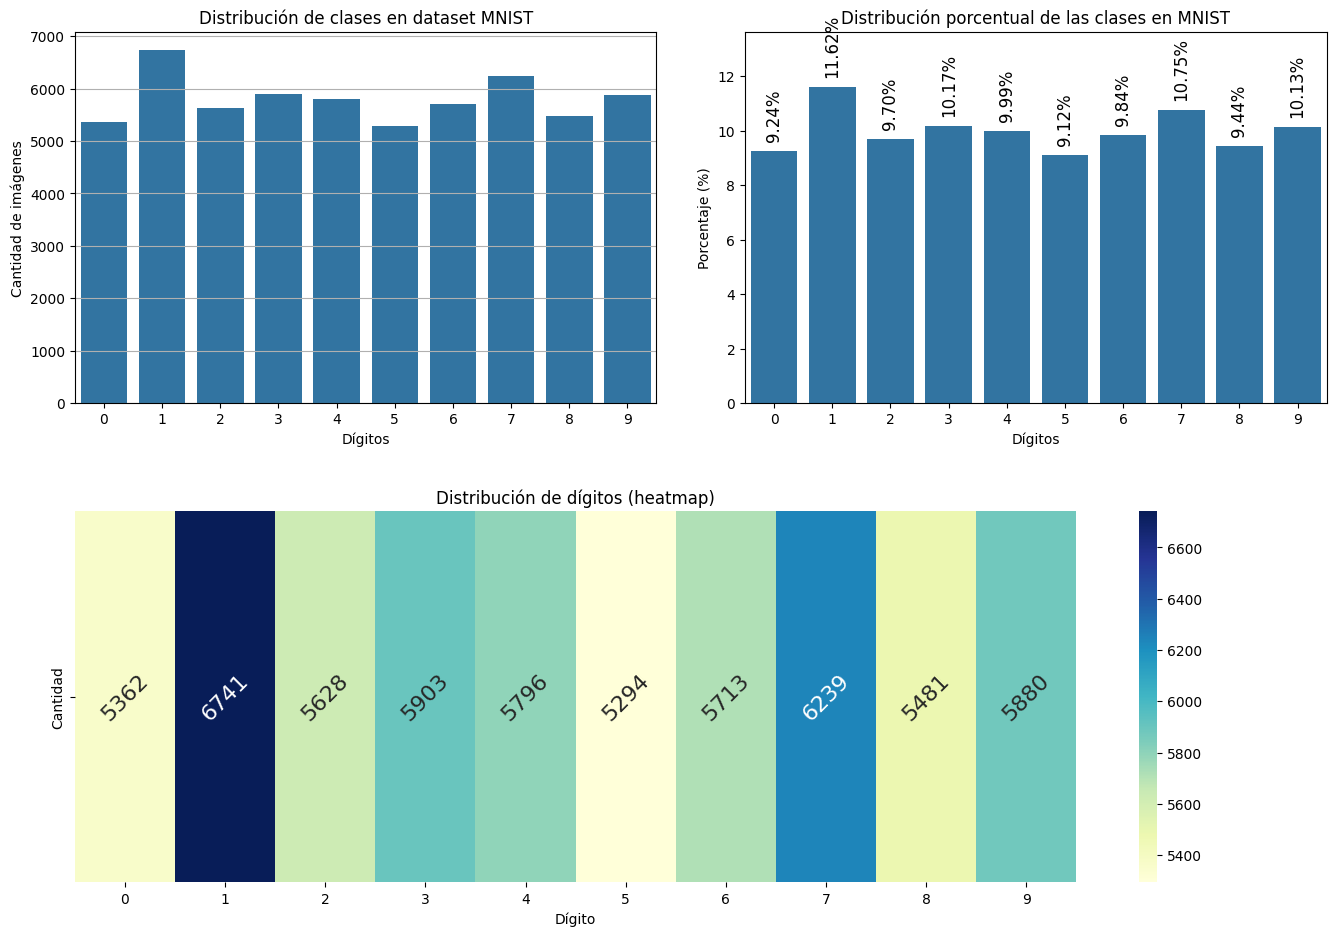

In [34]:
representar_dataset(y_train=y_train_final)


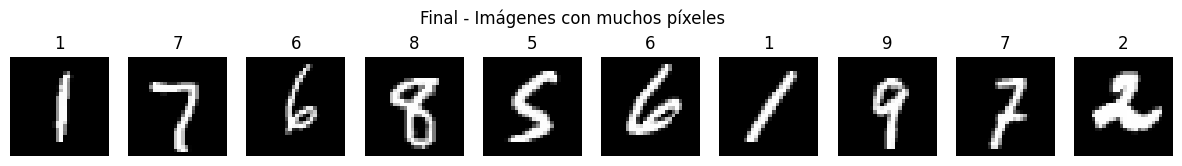

In [36]:

show_images(f"Final - Imágenes con muchos píxeles", high_pixel_non_zero_idxs[:10], x_train=x_train_final, y_train=y_train_final)


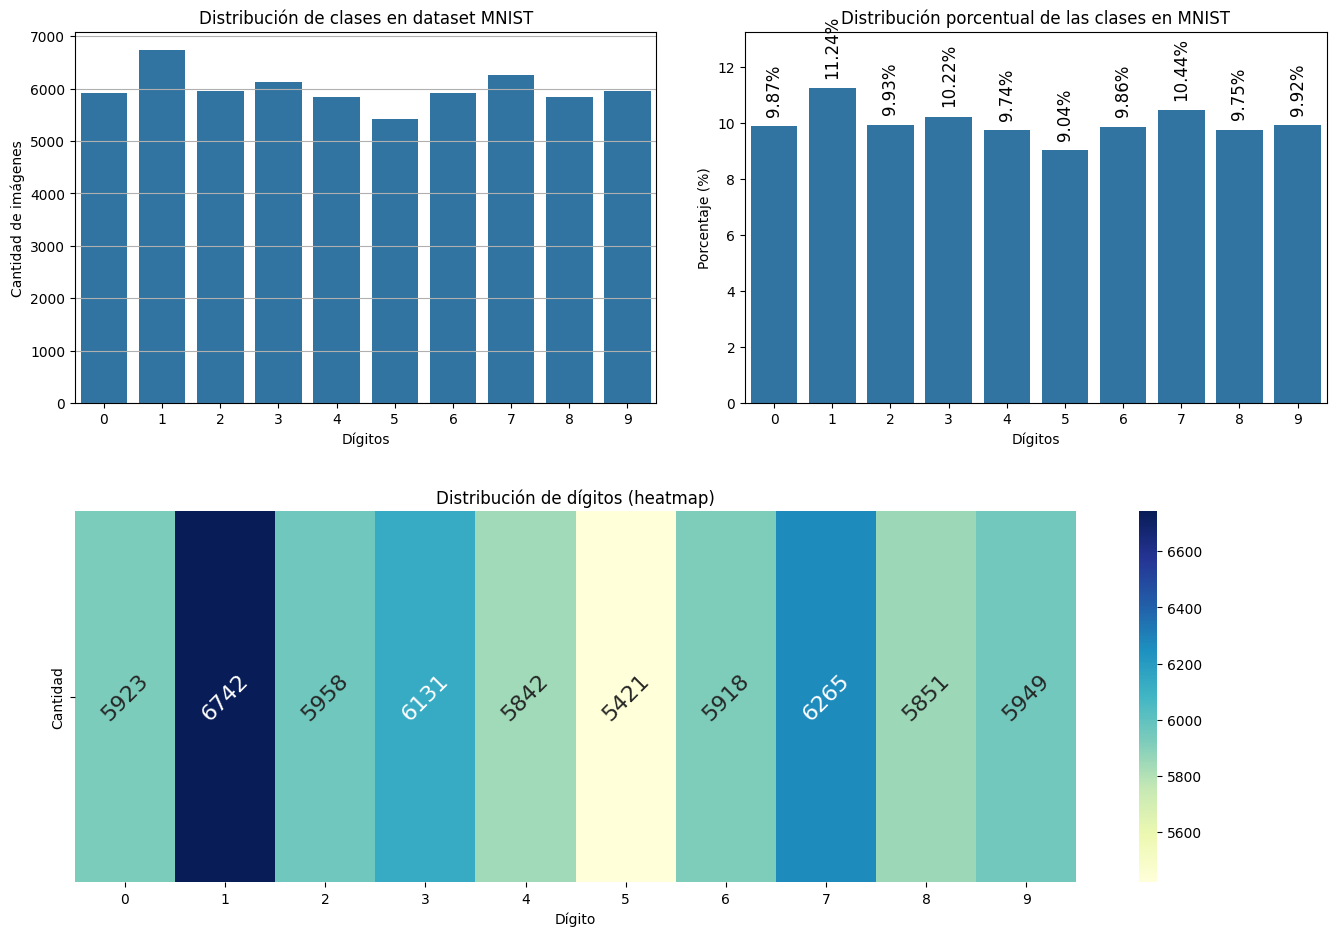

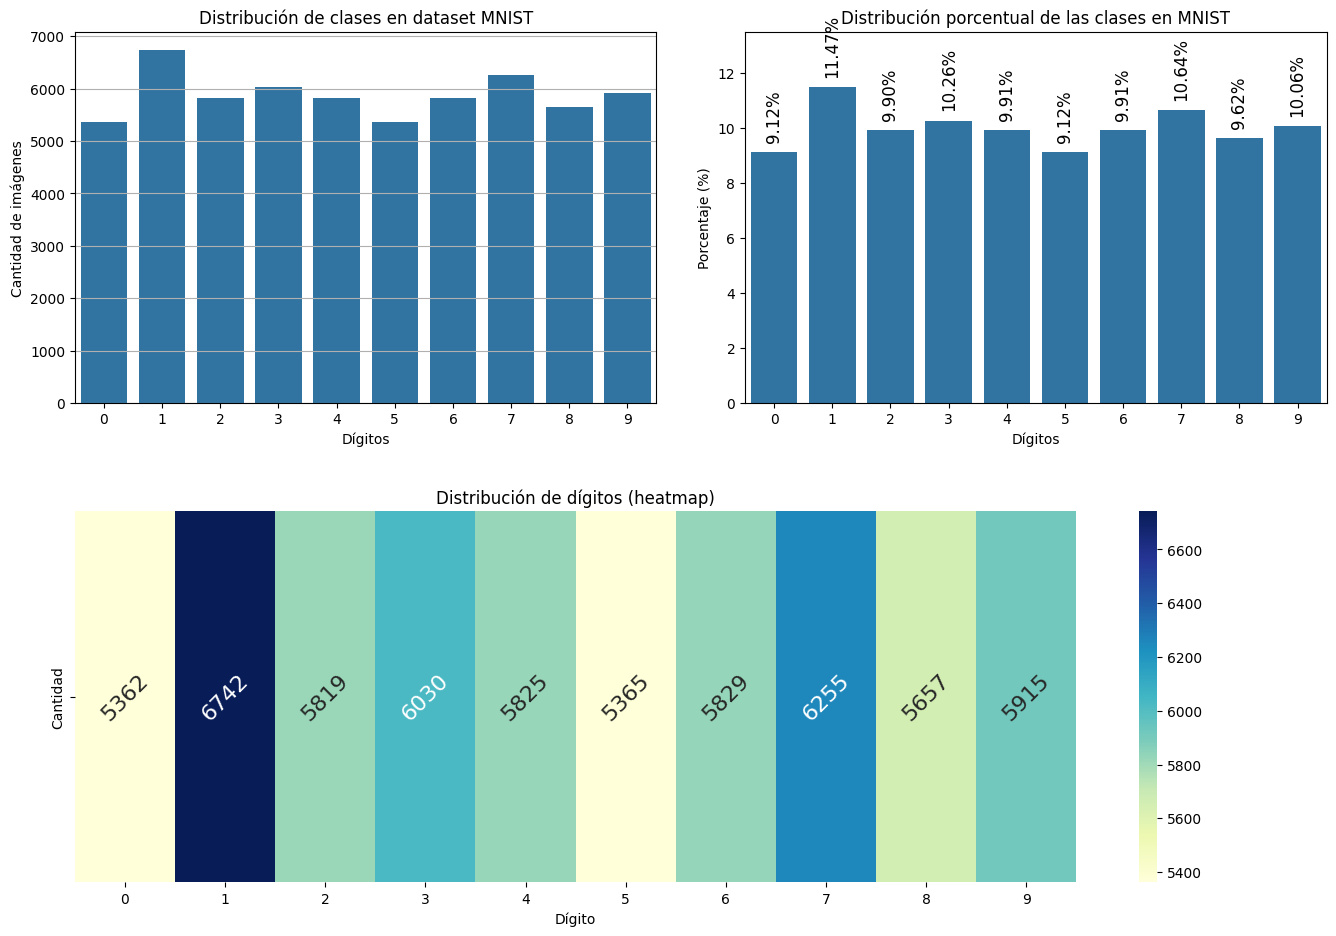

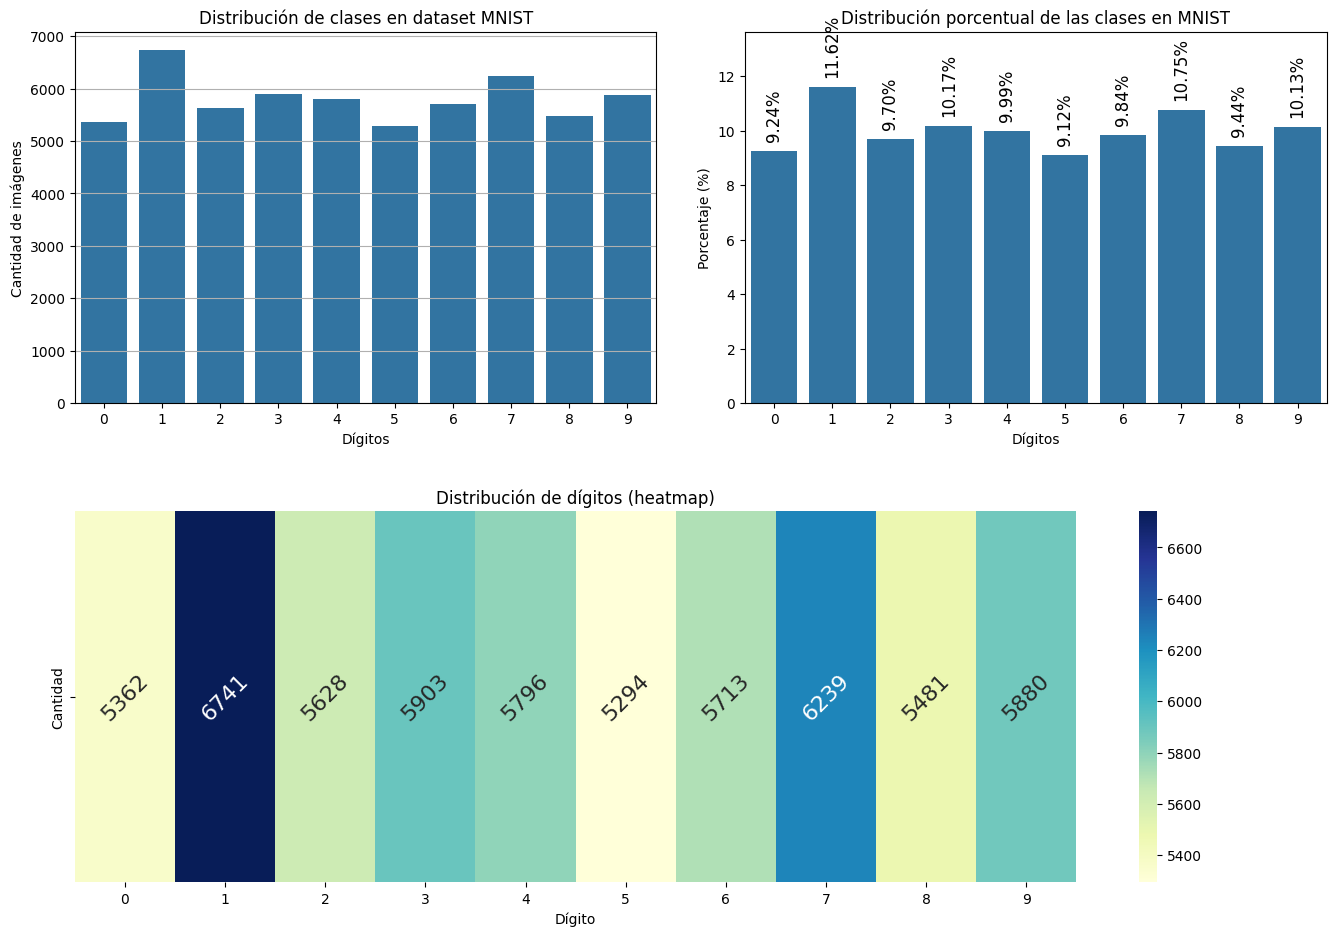

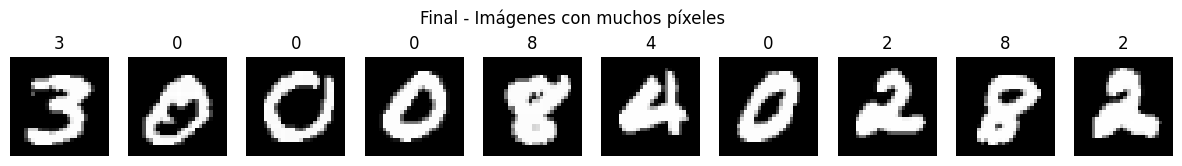

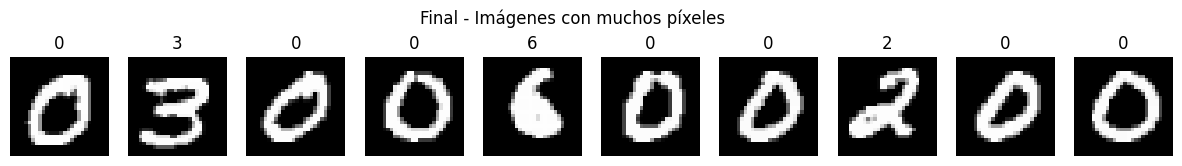

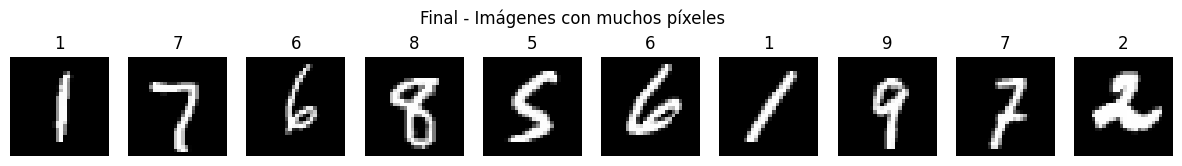

In [37]:
representar_dataset(y_train=y_train)
representar_dataset(y_train=y_train_cleaned)
representar_dataset(y_train=y_train_final)
show_images(f"Final - Imágenes con muchos píxeles", high_pixel_idxs[:10], x_train=x_train, y_train=y_train)
show_images(f"Final - Imágenes con muchos píxeles", high_pixel_idxs_cleaned[:10], x_train=x_train_cleaned, y_train=y_train_cleaned)
show_images(f"Final - Imágenes con muchos píxeles", high_pixel_non_zero_idxs[:10], x_train=x_train_final, y_train=y_train_final)

### Normalizacion de las imagenes

In [38]:
# Normalizar las imágenes a un rango [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0


In [39]:
# Redimensionar para agregar la dimensión de canal
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


In [52]:
from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos de entrenamiento en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x_train_final, y_train_final, test_size=0.15, stratify=y_train_final)

# Verificar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {x_train.shape}, Tamaño del conjunto de validación: {x_val.shape}")


Tamaño del conjunto de entrenamiento: (49331, 28, 28), Tamaño del conjunto de validación: (8706, 28, 28)


##### Transformacion en one-hot

In [78]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)


## 3. Model planning

### 3.1 Definicion del problema
- Tipo de Problema: Clasificación de imágenes, donde cada imagen representa un dígito del 0 al 9
- Objetivo: Lograr una alta precision, minimizando errores

### 3.2 Arquitectura de la red neuronal
- Capas convolucionales: al menos 2, con filtros incrementando en cantidad (32 y 64)
- Capas de pooling: tras cada capa convolucional aplicar una de MaxPooling
- Capas de activacion: funciones ReLU en cada capa para evitar linealidad
- Capa final: una capa fully connected (dense) con salida de 10 (una para digito) y activacion softmax

In [97]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),

    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=1, padding='same'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=1, padding='same'),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,442,762 (24.58 MB)

 Trainable params: 6,442,762 (24.58 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [99]:
if tf.config.list_physical_devices("GPU"):
    print("Usando GPU")
    with tf.device("/GPU:0"):
        # assert model.device.endswith("GPU:0")
        print("Dispositivo en el que se ejecuta TensorFlow:", tf.test.gpu_device_name())
        model.fit(x_train, y_train_one_hot, epochs=10, batch_size=16, validation_data=(x_val, y_val_one_hot))
else:
    print("NONO")

Usando GPU
Dispositivo en el que se ejecuta TensorFlow: /device:GPU:0
Epoch 1/10


I0000 00:00:1743982342.947936  118204 gpu_device.cc:2019] Created device /device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


3084/3084 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.2468 - loss: 3.4582 - val_accuracy: 0.8235 - val_loss: 0.6320
Epoch 2/10
3084/3084 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.7348 - loss: 0.7835 - val_accuracy: 0.9716 - val_loss: 0.0924
Epoch 3/10
3084/3084 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9377 - loss: 0.2118 - val_accuracy: 0.9804 - val_loss: 0.0693
Epoch 4/10
3084/3084 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9608 - loss: 0.1410 - val_accuracy: 0.9838 - val_loss: 0.0582
Epoch 5/10
3084/3084 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9692 - loss: 0.1053 - val_accuracy: 0.9844 - val_loss: 0.0579
Epoch 6/10
3084/3084 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9750 - loss: 0.0888 - val_accuracy: 0.9837 - val_loss: 0.0638
Epoch 7/10
3084/3084 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9771 - loss: 0.0837 - val_accuracy: 0.9874 - val_loss: 0.0498
Epoch 8/10
3084/3084 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9828 - loss: 0.0621 - val

In [100]:

results = model.evaluate(x_test, y_test_one_hot, verbose=0)

metric_names = ['Loss', 'Accuracy']

for name, result in zip(metric_names, results):
    if name=='Loss':
        print(f"{name}: {result}")
    else:
        print(f"{name}: {result * 100:.2f}")

Loss: 2.309788942337036
Accuracy: 10.09


In [101]:
def preprocess_image(image_data):
    # Open the image
    img = Image.open(io.BytesIO(image_data))
   
    # Convert to grayscale
    img = img.convert('L')
   
    # Resize to 28x28 pixels
    img = img.resize((28, 28))
   
    # Convert to numpy array
    img_array = np.array(img)
   
    # Normalize and reshape
    img_array = img_array.astype('float32') / 255
    img_array = img_array.reshape(-1, 28, 28, 1)
   
    return img_array

In [102]:
with open("imagen.png", "rb") as file:
    img_data = file.read()
    img_array = preprocess_image(img_data)

# Make prediction
prediction = model.predict(img_array)
predicted_digit = np.argmax(prediction[0])
confidence = float(prediction[0][predicted_digit])

# Convert the image to base64 for display
image = Image.open(io.BytesIO(img_data))
buffered = io.BytesIO()
image.save(buffered, format="PNG")
img_str = base64.b64encode(buffered.getvalue()).decode()

print({
    'prediction_list': prediction,
    'prediction': int(predicted_digit),
    'confidence': confidence,
    'image': img_str
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
{'prediction_list': array([[0.10705573, 0.08729275, 0.09567094, 0.11513998, 0.09091983,
        0.09887307, 0.0918273 , 0.08576471, 0.11609792, 0.11135779]],
      dtype=float32), 'prediction': 8, 'confidence': 0.11609791964292526, 'image': 'iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAA7klEQVR4nO2WsQ2EMAxFP1clm3mMlIxAyxTQUTIC47hkhKTzFQgJ0HE4Pkh1X3IB0tfLN4lDBUBQUK+SsD+wDJCIwMwQkdNiZoQQzFDZFjOLRjFGCSHI0a+o/YumaVTAVcycC85b4acFZabNbsmv0HzgGTjG+CwQgAzDsIM+DpznuRyQiHawruueBRrS6YFE9HUoKNPpgVcT6PZzeDWBlEfC/g2dc8+29Fh1XVs2jB243aHjOKp91UrN1RJqkfceKSWV75Ybf5om9YV8S0IASCnBe3/pMyc8ttA5p/KZgW3b7p77vlf5zC21qvhv4huamOY6bCepBgAAAABJRU5ErkJggg=='}
